In [177]:
import cv2
import numpy as  np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
from skimage.transform import resize


In [178]:
# Given a colored image, converts it to grayscale
def to_gray(img, r_frac, g_frac, b_frac):
    # first create an empty numpy array for the gray image
    h = img.shape[0]
    w = img.shape[1]
    grey_img = np.full((h, w), 0, dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            # calculate each new pixel based on the given fractions
            total = r_frac * img[y,x,0] + g_frac * img[y,x,1] + b_frac * img[y,x,2]
            grey_img[y,x] = np.uint8(total)
    return grey_img

# Given a grayscale image, apply full-scale contrast stretching
def contrast_stretching(image):
    new_img = image.copy()
    a = image.min()
    b = image.max()
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            new_img[y,x] = 255 * (image[y,x] - a) / (b - a)
    return new_img

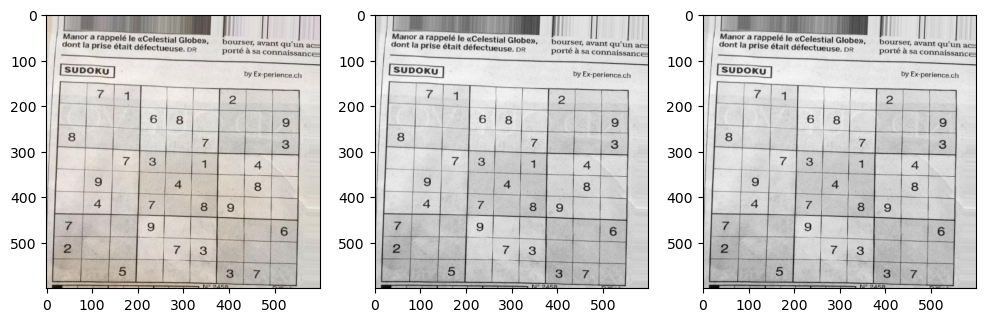

In [212]:
image = cv2.imread("sudoku_test_5.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = to_gray(image, 1/3, 1/3, 1/3)
fscs = contrast_stretching(gray)

f, plot = plt.subplots(1, 3, figsize=(12,12))
plot[0].imshow(image)
plot[1].imshow(gray, cmap='gray')
plot[2].imshow(fscs, cmap='gray')


In [ ]:
# Given a grayscale image, apply a gaussian blur to the image
def gaussian_blur(img, size, sig):
    # create a 2d array of gaussian pdf values
    filter = np.zeros((size, size), dtype=np.float32)
    for i in range(-size//2, size//2):
        for j in range(-size//2, size//2):
            filter[i+(size//2), j+(size//2)] = (1/(2.0 * np.pi * sig**2.0)) * np.exp(-1.0*(i**2.0 + j**2.0)/(2.0 * sig**2.0))
    filter /= np.sum(filter)

    # blur the image using convolution
    #   first get sizes
    padded_image = np.pad(img, int(size/2), mode='constant', constant_values = 255)
    imgH, imgW = padded_image.shape 
    filH, filW = filter.shape
    #   Create empty array
    temp = np.zeros(img.shape, dtype=float)   
    #   calc each pixel by sum
    for i in range(filH//2, imgH-filH+1):
        for j in range(filW//2, imgW-filW+1):
            temp[i, j] = np.sum(padded_image[i-filH//2:i+filH//2 + 1, j-filW//2:j+filW//2 + 1] * filter)
    return temp

def adaptive_thresh(img, size, sig, c):
    #First apply gaussian blurring
    blur = gaussian_blur(img, size, sig)

    # testing using the median as the constant thresh value
    # c = np.median(img, axis = None)
    
    #Next subtract a constant thresh value
    thresh = blur - c
    #binarize
    threshH, threshW = thresh.shape
    bin = np.zeros((threshH, threshW), dtype=np.uint8)
    img_temp = img[0:threshH, 0:threshW]
    bin[img_temp >= thresh] = 255

    return thresh, img_temp, bin


9 207.0


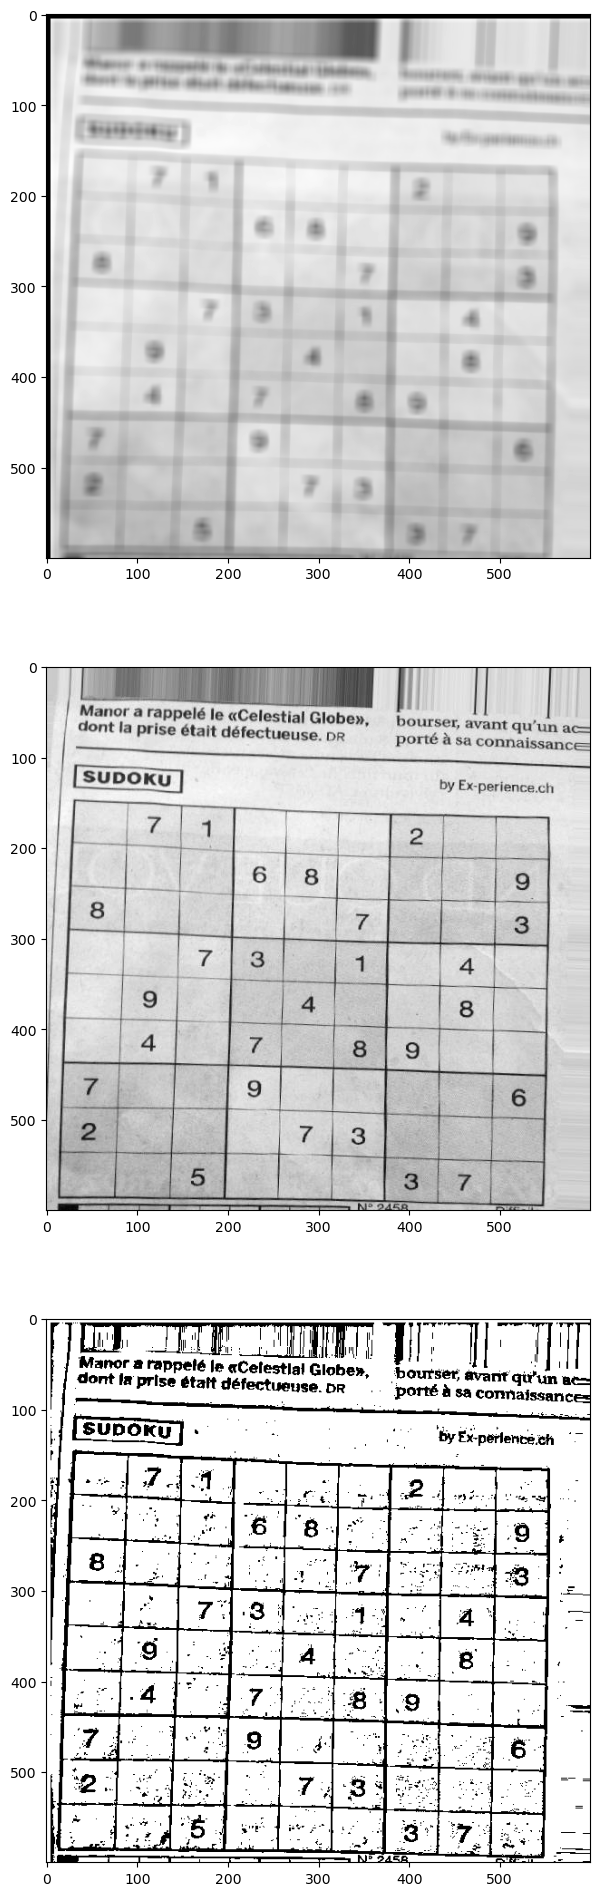

In [218]:
thresh, img_temp, bin = adaptive_thresh(gray, 11, 8, 9)

f, plot = plt.subplots(3, 1, figsize=(24,24))
plot[0].imshow(thresh, cmap='gray')
plot[1].imshow(img_temp, cmap='gray')
plot[2].imshow(bin, cmap='gray')

4 188.0
4 188.0
4 188.0


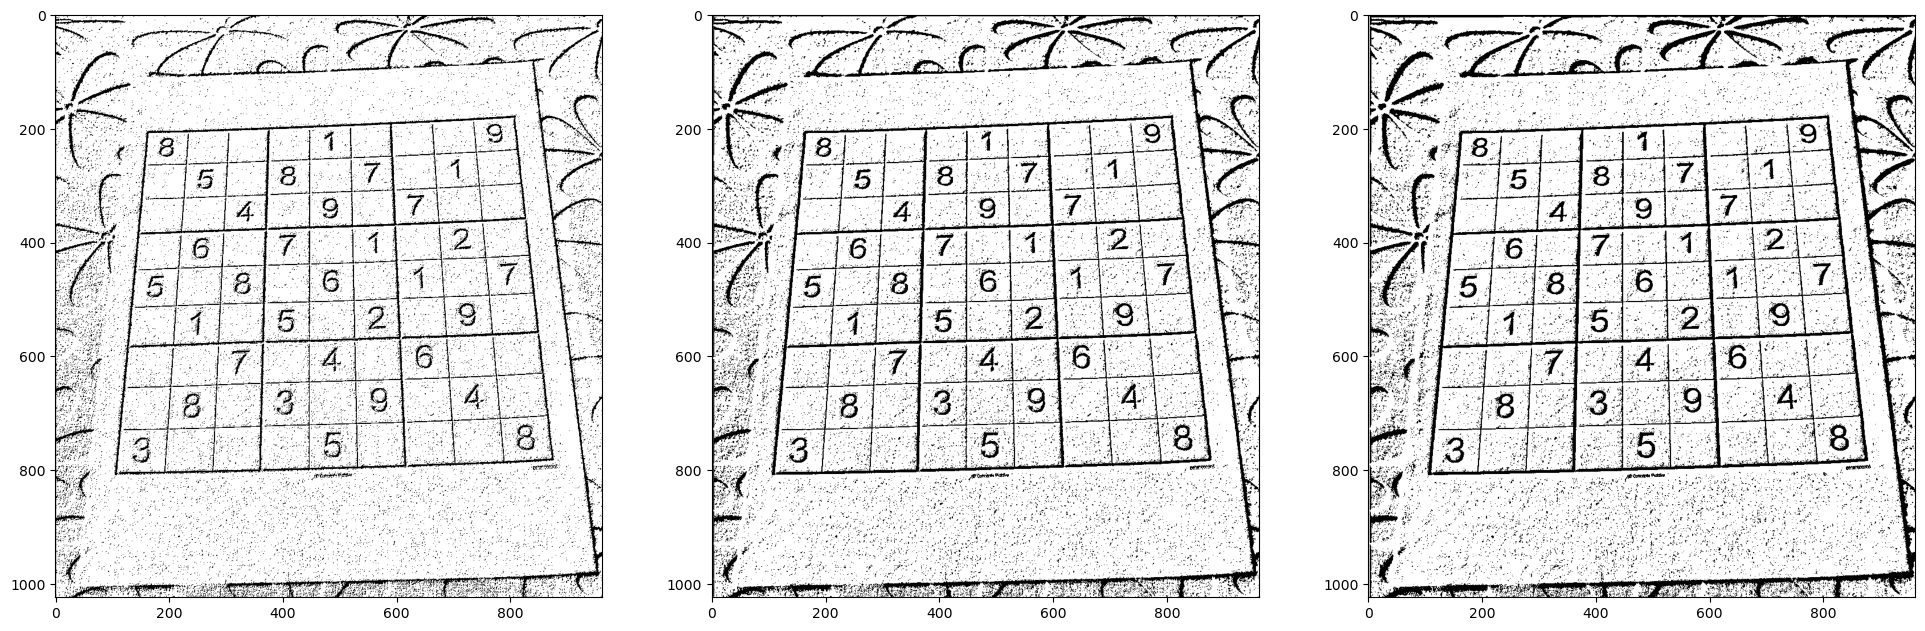

In [ ]:
f, plot = plt.subplots(1, 3, figsize=(24,24))
plot[0].imshow(adaptive_thresh(gray, 3, 6, 4)[2], cmap='gray')
plot[1].imshow(adaptive_thresh(gray, 5, 6, 4)[2], cmap='gray')
plot[2].imshow(adaptive_thresh(gray, 7, 6, 4)[2], cmap='gray')

In [221]:
thresh = adaptive_thresh(gray, 11, 8, 9)[2]

9 207.0


In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

def custom_dilate(img, kernel_size):
    padded_bin_image = np.pad(img, int(kernel_size/2), mode='edge')

    windowed_image = np.lib.stride_tricks.sliding_window_view(padded_bin_image, (kernel_size, kernel_size))

    flattened_image = windowed_image.reshape(-1, kernel_size ** 2)

    flattened_dilated_image = np.any(flattened_image, axis=1)

    dilated_image = flattened_dilated_image.reshape(img.shape)

    return dilated_image.astype(int)

def custom_erode(img, kernel_size):
    padded_bin_image = np.pad(img, int(kernel_size/2), mode='edge')

    windowed_image = np.lib.stride_tricks.sliding_window_view(padded_bin_image, (kernel_size, kernel_size))

    flattened_image = windowed_image.reshape(-1, kernel_size ** 2)

    flattened_eroded_image = np.all(flattened_image, axis=1)

    eroded_image = flattened_eroded_image.reshape(img.shape)

    return eroded_image.astype(int)

def opening(img, kernel_size):
    return custom_dilate(custom_erode(img, kernel_size), kernel_size)

def closing(img, kernel_size):
    return custom_erode(custom_dilate(img, kernel_size), kernel_size)

def open_close(img, kernel_size):
    return opening(closing(img, kernel_size), kernel_size)

def close_open(img, kernel_size):
    return closing(opening(img, kernel_size), kernel_size)

def median_filtering(img, kernel_size):
    padded_bin_image = np.pad(img, int(kernel_size/2), mode='edge')

    windowed_image = np.lib.stride_tricks.sliding_window_view(padded_bin_image, (kernel_size, kernel_size))

    flattened_image = windowed_image.reshape(-1, kernel_size ** 2)

    flattened_median_image = np.median(flattened_image, axis=1)

    median_image = flattened_median_image.reshape(img.shape)

    return median_image.astype(int)

Text(0.5, 1.0, 'img_ Median')

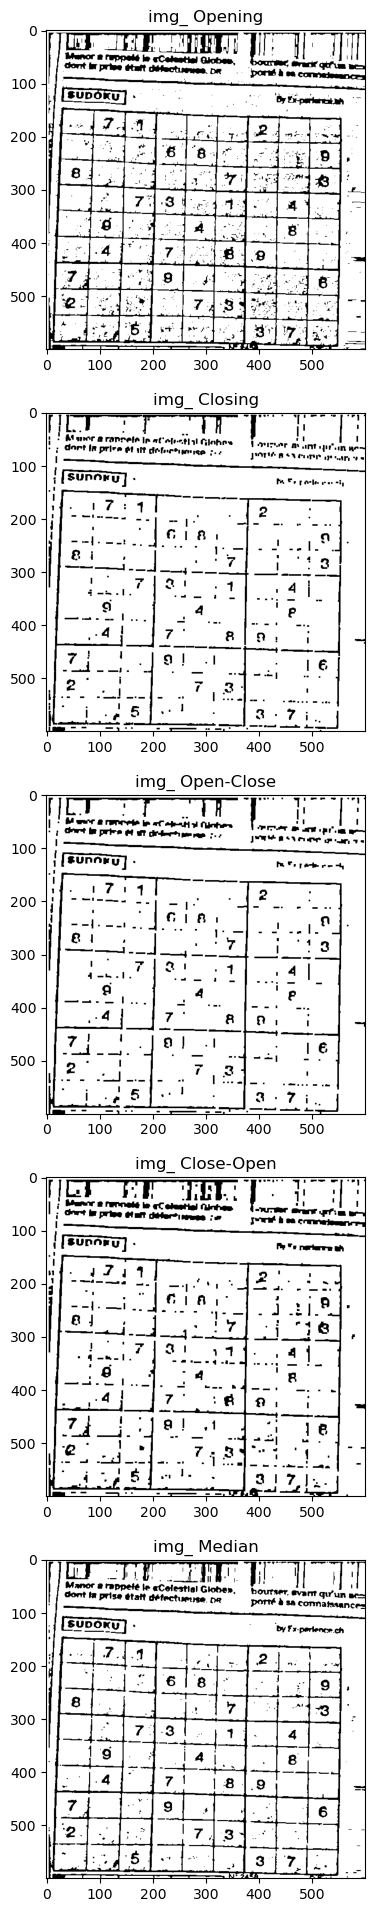

In [225]:
img_open = opening(thresh, 3)
img_close = closing(thresh, 3)
img_open_close = open_close(thresh, 3)
img_close_open = close_open(thresh, 3)
img_median = median_filtering(thresh, 3)

f, plot = plt.subplots(5, 1, figsize=(24,24))

plot[0].imshow(img_open, cmap = 'gray')
plot[0].set_title('img_ Opening')
plot[1].imshow(img_close, cmap = 'gray')
plot[1].set_title('img_ Closing')
plot[2].imshow(img_open_close, cmap = 'gray')
plot[2].set_title('img_ Open-Close')
plot[3].imshow(img_close_open, cmap = 'gray')
plot[3].set_title('img_ Close-Open')
plot[4].imshow(img_median, cmap = 'gray')
plot[4].set_title('img_ Median')

A morphological opening filter makes the grid most defined.

In [222]:
img_median = median_filtering(thresh, 5)

In [ ]:
# Given binary image of sudoku board, find a mask of the grid
def find_grid(bin):
    H = bin.shape[0]
    W = bin.shape[1]

    entity_map = np.zeros_like(bin, dtype=np.uint32)
    entity_num = 1

    for i in range(H):
        for j in range(W):
            if bin[i,j] != 255 and entity_map[i,j] == 0:
                stack = [(i,j)]
                while stack:
                    x,y = stack.pop()
                    if x >= 0 and x < H:
                        if y >= 0 and y < W:
                            if bin[x,y] != 255 and entity_map[x,y] == 0:
                                entity_map[x,y] = entity_num
                                stack.extend([(x-1,y-1),(x,y-1),(x+1,y-1),
                                              (x-1,y),          (x+1,y),
                                              (x-1,y+1),(x,y+1),(x+1,y+1)])
                entity_num += 1
    
    grid_label = np.argmax(np.bincount(entity_map[entity_map != 0].flatten()), n=3)
    grid = np.zeros_like(bin, dtype=np.uint8)
    grid[entity_map == grid_label] = 255

    return grid



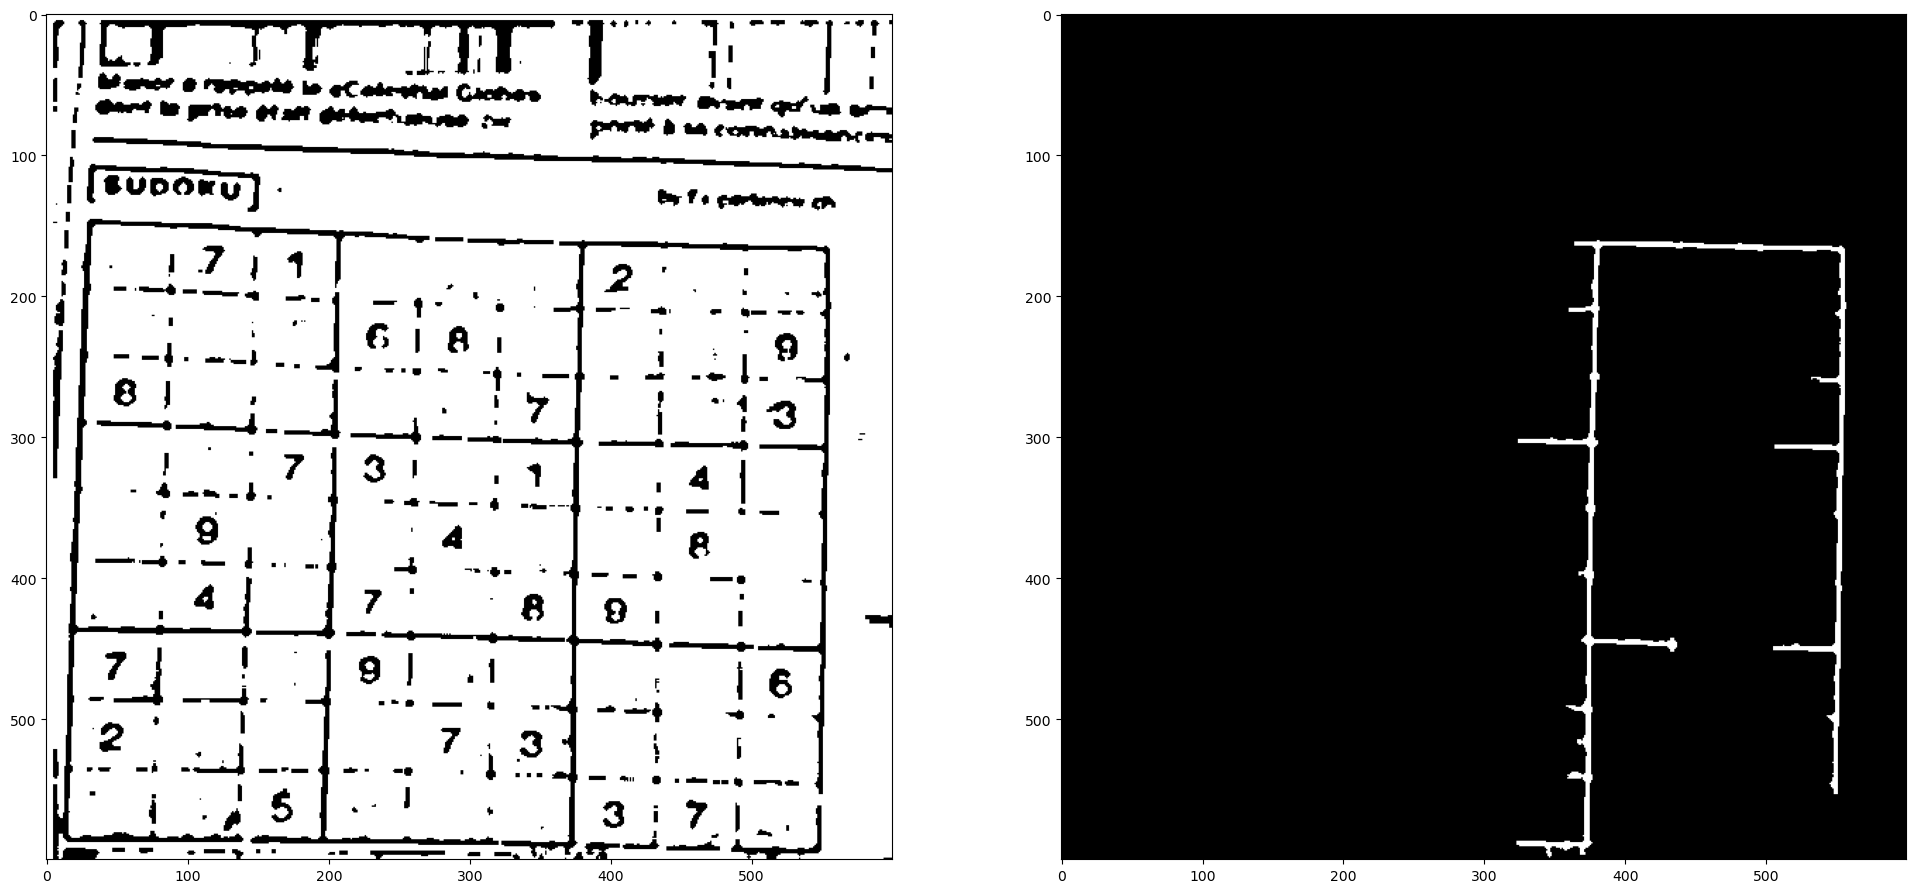

In [223]:
grid_mask = find_grid(img_median)
f, plot = plt.subplots(1, 2, figsize=(24,24))
plot[0].imshow(img_median, cmap = 'gray')
plot[1].imshow(grid_mask, cmap = 'gray')

In [ ]:
def find_botL(mask):
    H = mask.shape[0]
    W = mask.shape[1]

    curr_intercept = H-1
    curr_pixel = [H-1, 0]

    while mask[curr_pixel[0], curr_pixel[1]] == 0:
        next_pixel = [curr_pixel[0] + 1, curr_pixel[1] + 1]
        if next_pixel[0] >= H or next_pixel[1] >= W:
            next_pixel = [curr_intercept - 1, 0]
            curr_intercept -= 1
        if next_pixel[0] < 0:
            return (H-1,0)
        curr_pixel = next_pixel
    return curr_pixel

def find_topL(mask):
    H = mask.shape[0]
    W = mask.shape[1]

    curr_intercept = 0
    curr_pixel = [0, 0]

    while mask[curr_pixel[0], curr_pixel[1]] == 0:
        next_pixel = [curr_pixel[0] - 1, curr_pixel[1] + 1]
        if next_pixel[0] < 0 or next_pixel[1] >= W:
            next_pixel = [curr_intercept + 1, 0]
            curr_intercept += 1
        if next_pixel[0] >= H:
            return (0,0)
        curr_pixel = next_pixel
    return curr_pixel

def find_topR(mask):
    H = mask.shape[0]
    W = mask.shape[1]

    curr_intercept = 0
    curr_pixel = [0, W-1]

    while mask[curr_pixel[0], curr_pixel[1]] == 0:
        next_pixel = [curr_pixel[0] - 1, curr_pixel[1] - 1]
        if next_pixel[0] < 0 or next_pixel[1] < 0:
            next_pixel = [curr_intercept + 1, W - 1]
            curr_intercept += 1
        if next_pixel[0] >= H:
            return (0,W-1)
        curr_pixel = next_pixel
    return curr_pixel

def find_botR(mask):
    H = mask.shape[0]
    W = mask.shape[1]

    curr_intercept = H-1
    curr_pixel = [H-1, W-1]

    while mask[curr_pixel[0], curr_pixel[1]] == 0:
        next_pixel = [curr_pixel[0] + 1, curr_pixel[1] - 1]
        if next_pixel[0] >= H or next_pixel[1] < 0:
            next_pixel = [curr_intercept - 1, W - 1]
            curr_intercept -= 1
        if next_pixel[0] < 0:
            return (H-1,W-1)
        curr_pixel = next_pixel
    return curr_pixel

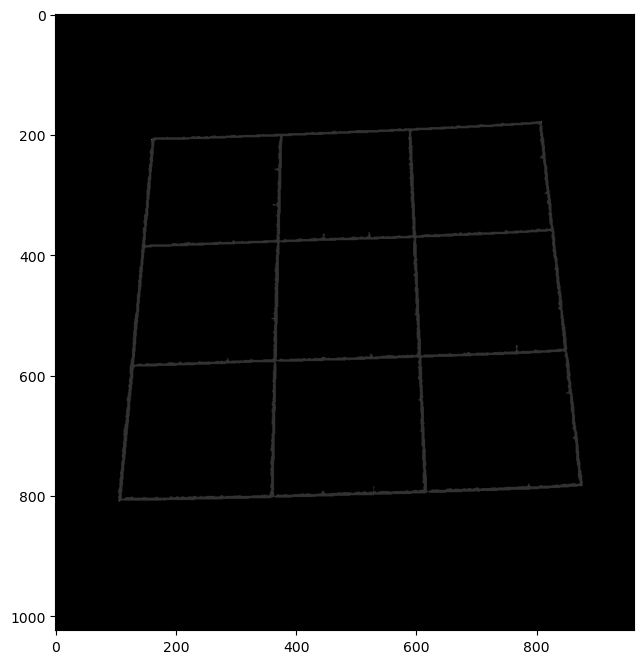

In [ ]:
grid_mask = find_grid(img_median)

botL = find_botL(grid_mask)
topL = find_topL(grid_mask)
botR = find_botR(grid_mask)
topR = find_topR(grid_mask)

grid_mask[grid_mask == 255] = 50
grid_mask[botL[0], botL[1]] = 255
grid_mask[topL[0], topL[1]] = 255
grid_mask[botR[0], botR[1]] = 255
grid_mask[topR[0], topR[1]] = 255

f, plot = plt.subplots(1, 1, figsize=(8,8))
plot.imshow(grid_mask, cmap = 'gray')

In [ ]:
def get_transform_matrix(input_pts, output_pts):
    matrix = []
    for i in range(4):
        X, Y = input_pts[i]
        x, y = output_pts[i]
        matrix.append([x, y, 1, 0, 0, 0, -1*X*x, -1*X*y])
        matrix.append([0, 0, 0, x, y, 1, -1*Y*x, -1*Y*y])
    
    A = np.matrix(matrix, dtype=np.float32)
    B = np.array(input_pts).reshape(8)
    Lambda = np.linalg.solve(A, B)
    return np.array(Lambda).reshape(8)

def transform(img, matrix):
    height, width = img.shape
    warped_image = np.zeros_like(img)

    for y in range(height):
        for x in range(width):
            src_coords = np.array([x, y, 1], dtype=np.float32)
            dst_coords = np.dot(matrix, src_coords)
            warped_x, warped_y = dst_coords[:2] / dst_coords[2]

            # Check if the new coordinates are within the bounds
            if 0 <= warped_x < width and 0 <= warped_y < height:
                warped_image[int(warped_y), int(warped_x)] = img[y, x]

    return warped_image

In [ ]:
H = gray.shape[0]
W = gray.shape[1]

input_pts = [(topL[1], topL[0]),
             (topR[1], topR[0]),
             (botR[1], botR[0]),
             (botL[1], botL[0])]
output_pts = [(0,0), (W, 0), (W, H), (0, H)]

transform_matrix = get_transform_matrix(input_pts, output_pts)
pil_img = Image.fromarray(gray)
pil_img.transform((W, H), Image.PERSPECTIVE, transform_matrix, Image.BICUBIC).show()

In [219]:
def get_board(image):
    #first get grayscale image
    gray = to_gray(image, 1/3, 1/3, 1/3)

    #use adaptive gaussian thresholding to convert to binary image
    bin = adaptive_thresh(gray, 11, 8, 9)[2]

    #Use morphology opening filter to better detect borders
    img_open = median_filtering(bin, 5)

    #isolate the grid and find the 4 corners of the playing board
    grid_mask = find_grid(img_open)
    botL = find_botL(grid_mask)
    topL = find_topL(grid_mask)
    botR = find_botR(grid_mask)
    topR = find_topR(grid_mask)

    #calculate a perspective transformation to straighten board (from grayscale image)
    H = gray.shape[0]
    W = gray.shape[1]

    input_pts = [(topL[1], topL[0]),
                (topR[1], topR[0]),
                (botR[1], botR[0]),
                (botL[1], botL[0])] #gather current corner coordinates
    output_pts = [(0,0), (W, 0), (W, H), (0, H)] #gather tranformed corner coordinates

    transform_matrix = get_transform_matrix(input_pts, output_pts) #calc transform matrix
    pil_img = Image.fromarray(gray) #convert opencv img to PIL img
    pil_board = pil_img.transform((W, H), Image.PERSPECTIVE, transform_matrix, Image.BICUBIC) #apply matrix transform to each pixel
    board = np.array(pil_board) #convert PIL image to OpenCV image

    # apply adaptive gaussian filtering and morphological closing to better view the numbers
    # board_bin = adaptive_thresh(board, 15, 6, 4)[2]
    # board_closing = closing(board_bin, 5)

    return board

9 137.0


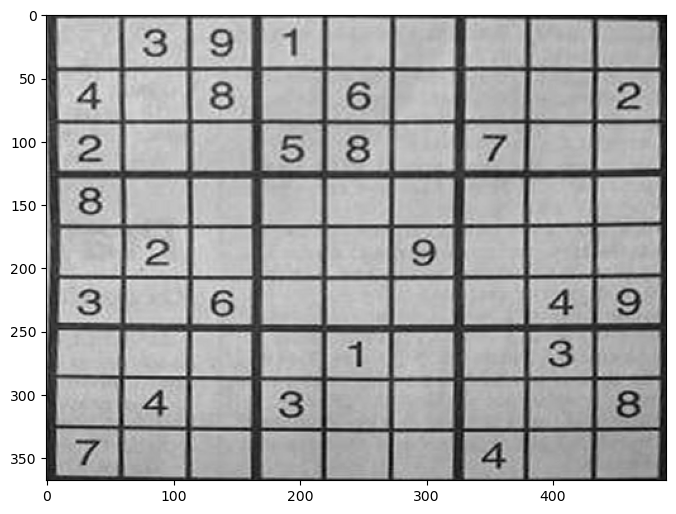

In [293]:
# from Sudoku_Board1 import get_board

image = cv2.imread("sudoku_test_3.jpg")
board = get_board(image)

f, plot = plt.subplots(1, 1, figsize=(8,8))
plot.imshow(board, cmap = 'gray')
plt.show()

3 146.0
4 146.0
5 146.0
3 146.0
4 146.0
5 146.0


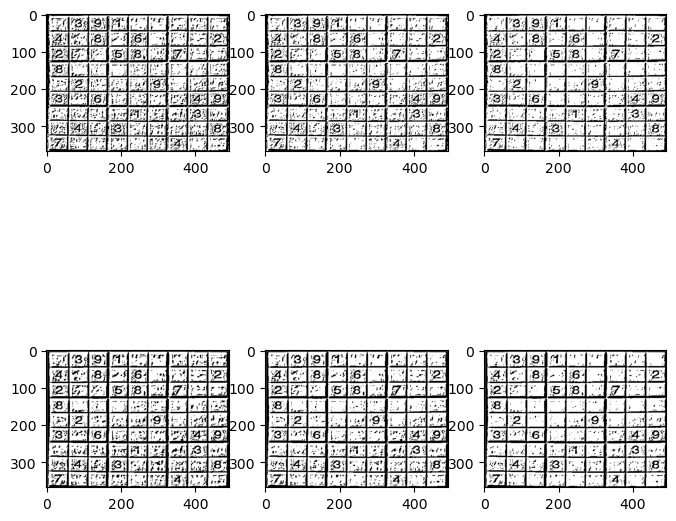

In [ ]:
f, plot = plt.subplots(2, 3, figsize=(8,8))
plot[0,0].imshow(adaptive_thresh(board, 5, 6, 3)[2], cmap='gray')
plot[0,1].imshow(adaptive_thresh(board, 5, 6, 4)[2], cmap='gray')
plot[0,2].imshow(adaptive_thresh(board, 5, 6, 5)[2], cmap='gray')
plot[1,0].imshow(adaptive_thresh(board, 7, 6, 3)[2], cmap='gray')
plot[1,1].imshow(adaptive_thresh(board, 7, 6, 4)[2], cmap='gray')
plot[1,2].imshow(adaptive_thresh(board, 7, 6, 5)[2], cmap='gray')

15 146.0


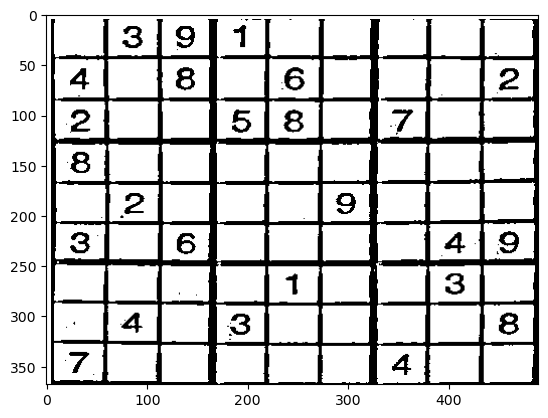

In [294]:
board_thresh = adaptive_thresh(board, 11, 8, 15)[2]

plt.imshow(board_thresh, cmap="gray")
plt.show()

Text(0.5, 1.0, 'img_ Median')

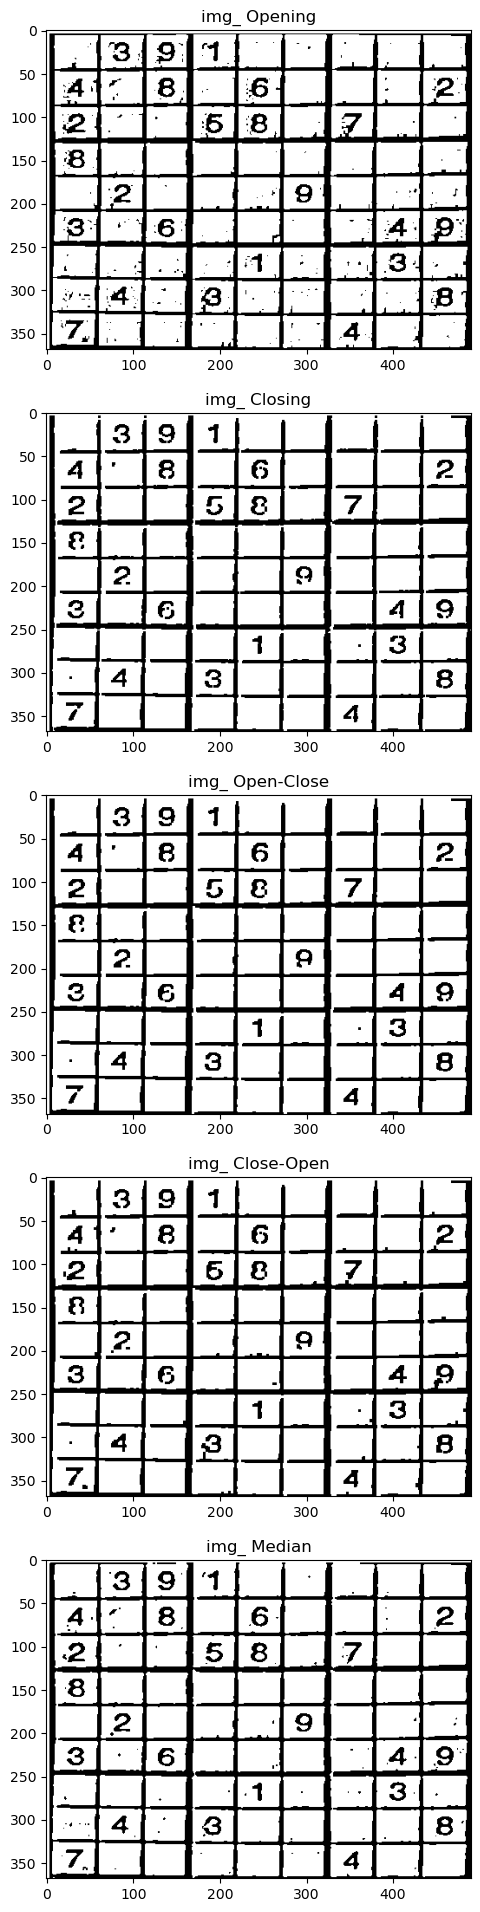

In [ ]:
img_open = opening(board_thresh, 3)
img_close = closing(board_thresh, 3)
img_open_close = open_close(board_thresh, 3)
img_close_open = close_open(board_thresh, 3)
img_median = median_filtering(board_thresh, 3)

f, plot = plt.subplots(5, 1, figsize=(24,24))

plot[0].imshow(img_open, cmap = 'gray')
plot[0].set_title('img_ Opening')
plot[1].imshow(img_close, cmap = 'gray')
plot[1].set_title('img_ Closing')
plot[2].imshow(img_open_close, cmap = 'gray')
plot[2].set_title('img_ Open-Close')
plot[3].imshow(img_close_open, cmap = 'gray')
plot[3].set_title('img_ Close-Open')
plot[4].imshow(img_median, cmap = 'gray')
plot[4].set_title('img_ Median')

In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)


In [296]:
batch_size = 64
num_classes = 10
epochs = 5

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     validation_split=0.1,
#                     )

model.load_weights('./checkpoints/my_checkpoint')

In [194]:
new_model = tf.keras.models.load_model('drecv2')

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

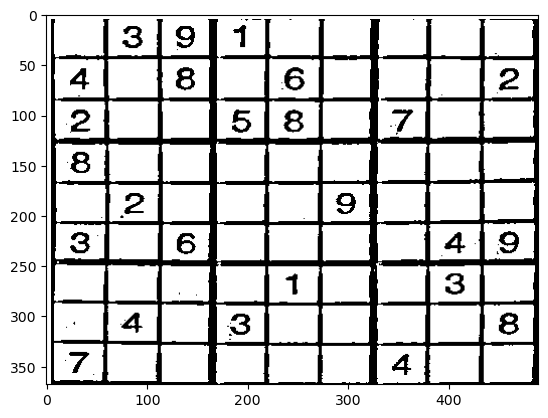

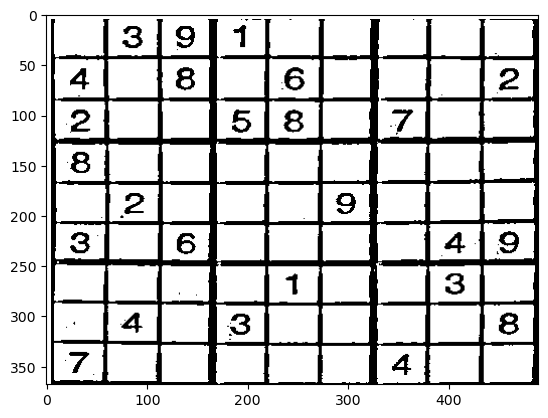

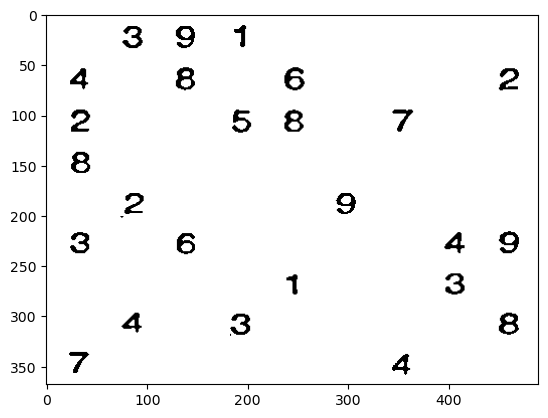

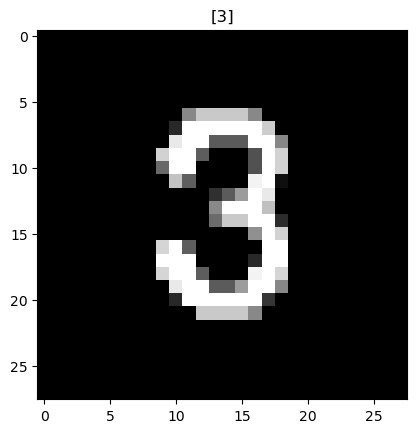

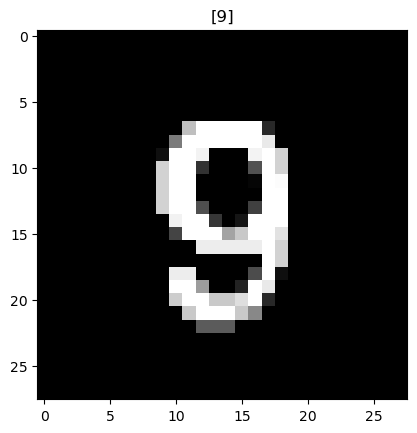

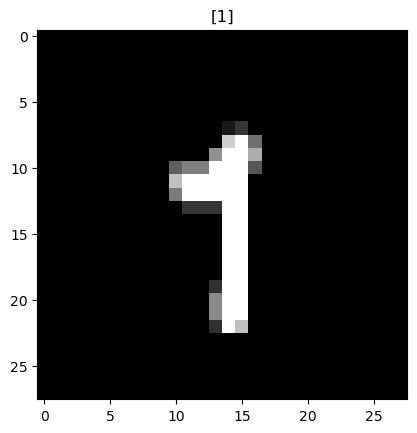

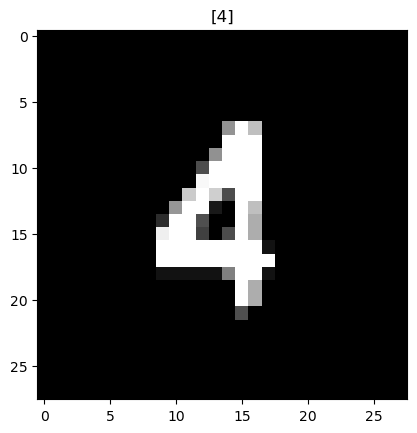

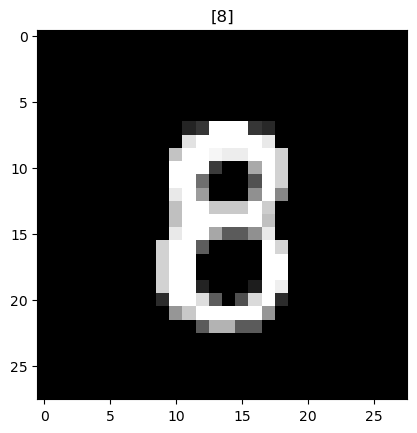

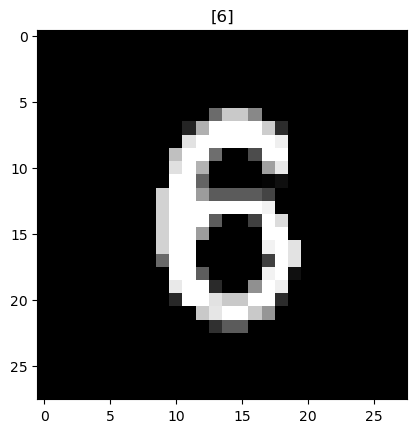

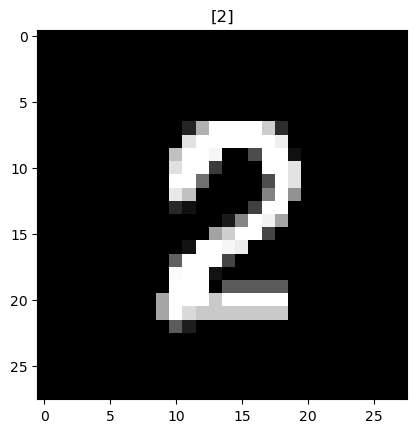

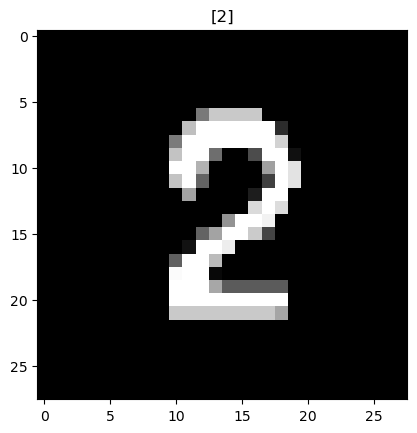

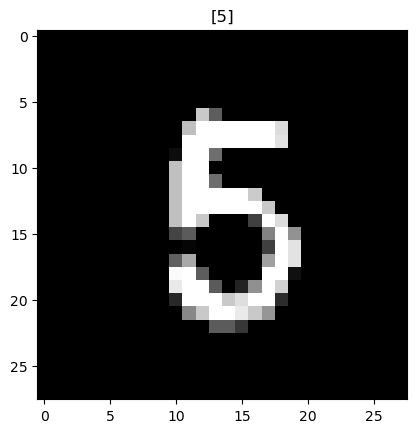

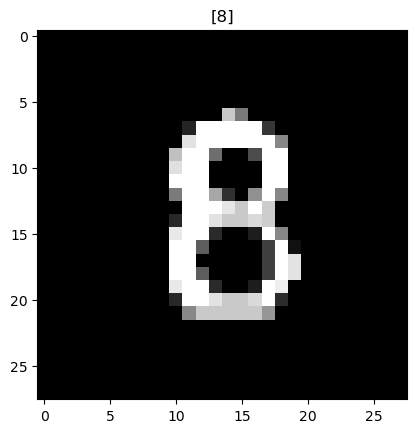

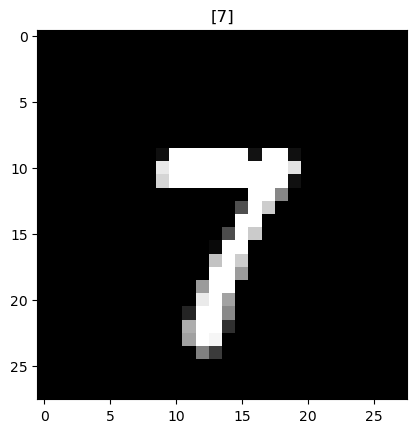

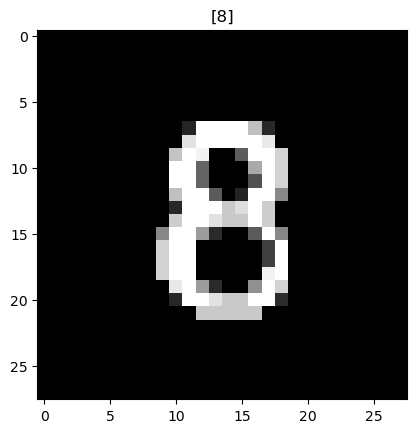

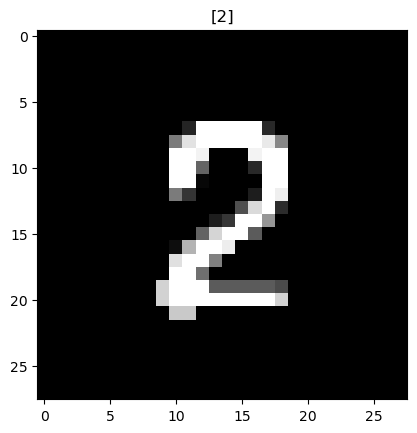

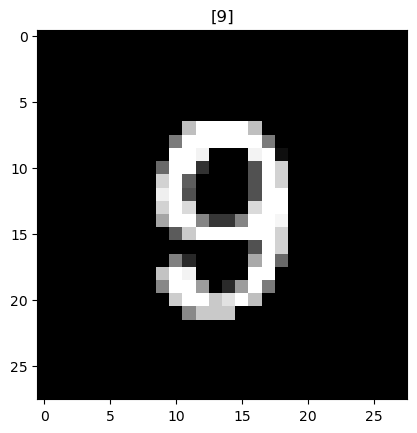

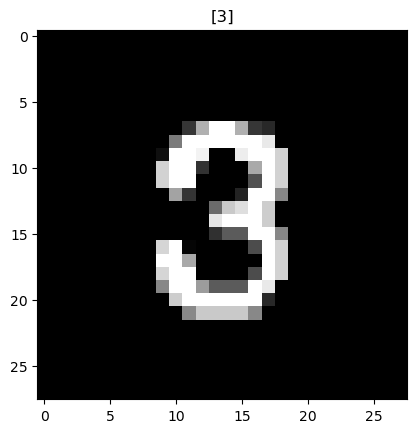

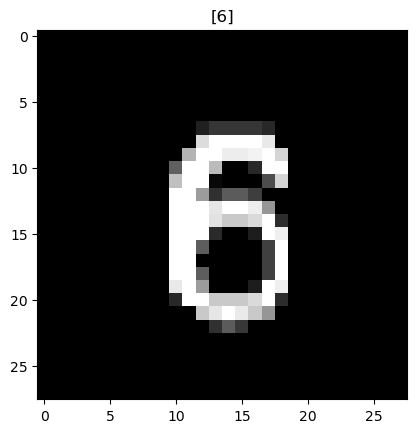

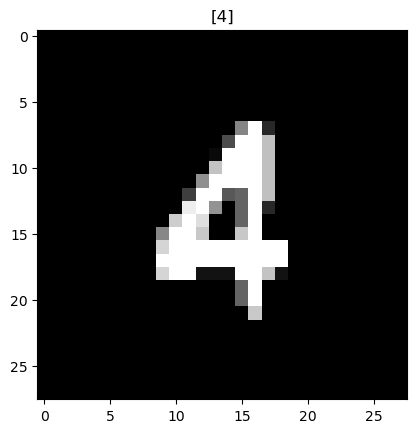

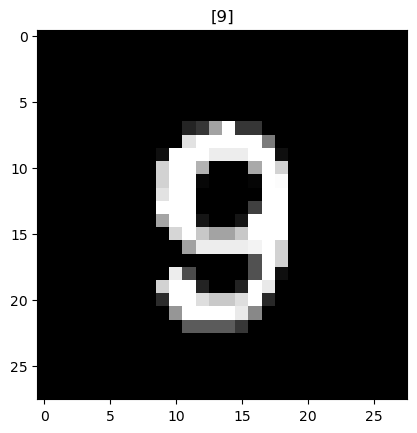

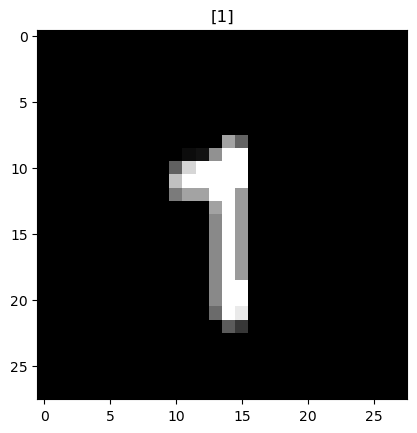

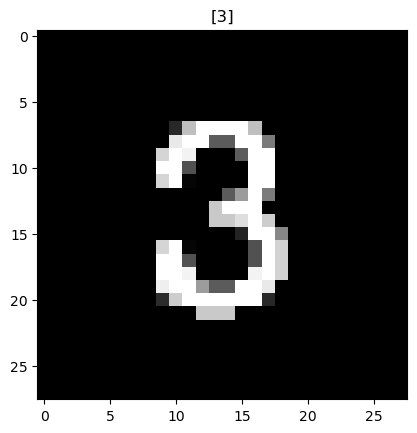

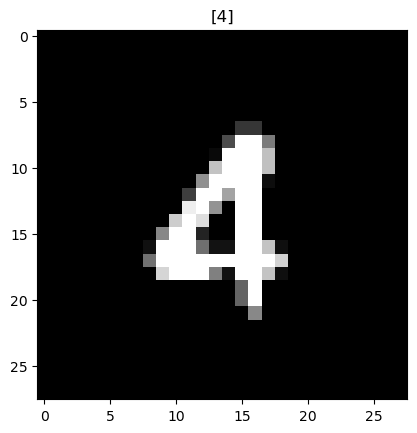

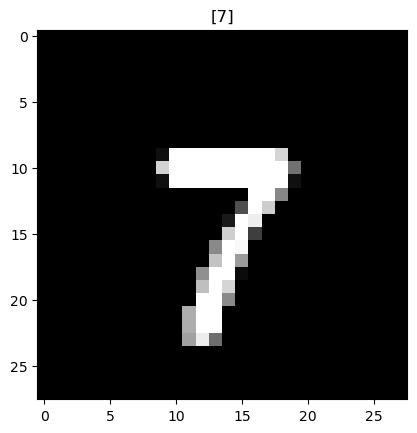

25


In [297]:
# Naive Approach, find cells by dividing imagine into 9x9 squares (assumes decent board)

processed_board = board_thresh.copy()

# processed_board = opening(processed_board, 3)

plt.imshow(processed_board, cmap="gray")
plt.show()

cv2.floodFill(processed_board, None, (processed_board.shape[1]-1, processed_board.shape[0]-1), 0)
plt.imshow(processed_board, cmap="gray")
plt.show()

cv2.floodFill(processed_board, None, (processed_board.shape[1]-1, processed_board.shape[0]-1), 255)

processed_board = np.array(median_filtering(processed_board, 3), np.uint8)

plt.imshow(processed_board, cmap="gray")
plt.show()

counter = 0

height_step = processed_board.shape[0] // 9
width_step = processed_board.shape[1] // 9

for i in range(0, 9):
    for j in range(0, 9):
        cell_img = processed_board[i*height_step:(i+1)*height_step, j*width_step:(j+1)*width_step]

        cell_img = cv2.bitwise_not(cell_img)
        contours = 0
        contours = cv2.findContours(cell_img.copy(), cv2.RETR_TREE,
            cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        if len(contours) == 0:
            continue

        c = max(contours, key=cv2.contourArea)
        mask = np.zeros(cell_img.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

        (h, w) = cell_img.shape
        percentFilled = cv2.countNonZero(cell_img) / float(w * h)

        if percentFilled < 0.03:
            continue

        counter += 1
        # plt.imshow(cell_img, cmap="gray")
        # plt.show()
        mass_x, mass_y = np.where(cell_img >= 255)

        cent_x = int(np.round(np.average(mass_x)))
        cent_y = int(np.round(np.average(mass_y)))

        real_cent_x = int(np.round(cell_img.shape[0]/2))
        real_cent_y = int(np.round(cell_img.shape[1]/2))

        dx = cent_x - real_cent_x
        dy = cent_y - real_cent_y


        centered_cell = np.zeros(cell_img.shape)
        # try:
        if dx > 0 and dy > 0:
            centered_cell[:-1*dx, :-1*dy] = cell_img[dx:, dy:]
        elif dx < 0 and dy > 0:
            centered_cell[-1*dx:, :-1*dy] = cell_img[:dx, dy:]
        elif dx > 0 and dy < 0:
            centered_cell[:-1*dx, -1*dy:] = cell_img[dx:, :dy]
        elif dx < 0 and dy < 0:
            centered_cell[-1*dx:, -1*dy:] = cell_img[:dx, :dy]
        elif dx > 0 and dy == 0:
            centered_cell[:-1*dx, :] = cell_img[dx:, :]
        elif dx < 0 and dy == 0:
            centered_cell[-1*dx:, :] = cell_img[:dx, :]
        elif dx == 0 and dy > 0:
            centered_cell[:, :-1*dy] = cell_img[:, dy:]
        elif dx == 0 and dy < 0:
            centered_cell[:, -1*dy:] = cell_img[:, :dy]
        else:
            centered_cell = cell_img

        # except:
        #     centered_cell = cell_img

        # plt.imshow(centered_cell, cmap="gray")
        # plt.title(f"{dx}, {dy}")
        # plt.show()

        resized_cell = cv2.resize(centered_cell, (28, 28))

        processed_cell = resized_cell.reshape(1, 28, 28) / 255

        predicted = model.predict(processed_cell)
        
        plt.imshow(resized_cell, cmap="gray")
        plt.title(np.argmax(predicted, axis = 1))
        plt.show()

print(counter)